# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Inteligencia Artificial y Aprendizaje Automático**
#### Tecnológico de Monterrey
#### Prof Luis Eduardo Falcón Morales

### **Semana: Autoencoders y Técnicas de Conglomerados (Clustering)**

Marcos Eduardo García Ortiz


A01276213

# **Introducción**

#### Sabemos que kMeans es un método de clasificación (clustering) no supervisado que nos ayuda a encontrar subgrupos de datos similares dentro de un conjunto de datos. Veamos ahora el efecto que puedan tener diferentes técnicas de reducción de dimensionalidad, Autoencoders y PCA, en la calidad de dichos subgrupos.

La página inicial de Kaggle de donde proceden dichos datos se desactualizó, pero mientras la acutalizan, el archivo de los datos estará en Canvas.

El archivo consta de 15,000 registros con 9 factores para un problema de ambiente de trabajo en una organización (entre ellos el problema de rotación de personal como ya estudiamos en semanas anteriores) con variables numéricas y categóricas.

La idea es usar técnicas de Autoencoders y PCA, en combinación con el método de KMeans, para encontrar subgrupos o cúmulos de personas que nos den información sobre el ambiente de trabajo dentro de dicha organización.

Las técnicas que aplicaremos son técnicas no supervisadas, ya que no tenemos la información en relación a un problema de clasificación o regresión.



Así, usaremos técnicas de reducción de dimensionalidad para identificar subgrupos similares de empleados a través de información proporcionada por el archivo proveniente de recursos humanos. Primero vamos a identificar los subgrupos y después vamos predecir qué datos están en cada subgrupo.

Para entender lo que nos dicen dichos subgrupos desde un punto de vista de negocio, necesitamos analizar dichos subrupos con respecto a los factores iniciales. Es decir, ¿qué tienen en común los empleados que están en un mismo subgrupo?

Recuerda que la manera en que funciona el método del codo (elbow method) para seleccionar el mejor número de subrupos en la técnica de kMeans, es buscando la cantidad de cúmulos que nos lleve a la suma más baja de distancias al cuadrado (llamada "inercia"), es decir, donde la inercia no sufra cambios importantes al seguir aumentando la cantidad de cúmulos.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, load_model

from keras.optimizers import SGD

from sklearn.preprocessing import OrdinalEncoder

# comentemos por el momento los posibles Warnings:
from warnings import filterwarnings
filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import os
DIR = "/content/drive/MyDrive/Maestria/Segundo Trimestre/IAyAA/Actividad 7/"
os.chdir(DIR)

Mounted at /content/drive


# **Funciones para gráficas de la última parte de esta atcividad.**

In [60]:
# Esta celda contiene las funciones para generar varios de los
# gráficos que requeriremos en esta actividad.

# Definimos la función de gráficos con datos numéricos:

def mi_scatterplotPCAEncoder(perfil_Zencoder, perfil_pca, fact1, fact2):

  plt.figure(figsize=(15,10))
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,15))

  sns.scatterplot(data=perfil_Zencoder,
                  x= fact1,
                  y= fact2,
                  hue='autoencoder_clusters',
                  s=85,
                  alpha=0.4,
                  palette='bright',
                  ax=ax1
                  ).set_title('(AutoEncoder) Cúmulos',fontsize=18)

  sns.scatterplot(data=perfil_pca,
                  x=fact1,
                  y=fact2,
                  hue='pca_clusters',
                  s=85,
                  alpha=0.6,
                  palette='bright'
                  ).set_title('(PCA) Cúmulos',fontsize=18)



# Definimos la función de gráficos con variables categóricas:

def mi_catplotPCAEncoder(perfil_Zencoder, perfil_pca, fact1, fact2):

  plt.figure(figsize=(15,10))
  fig = plt.subplots(1,2, figsize=(20,15))

  ax1 = sns.catplot(data=perfil_Zencoder,
                    x= fact1,
                    y= fact2,
                    hue='autoencoder_clusters',
                    jitter=0.6,
                    s=20,
                    alpha=0.6,
                    palette='bright',
                    legend_out=True
                    )

  ax2 = sns.catplot(data=perfil_pca,
                    x=fact1,
                    y=fact2,
                    hue='pca_clusters',
                    jitter=0.6,
                    s=20,
                    alpha=0.6,
                    palette='bright',
                    legend_out=True
                    )

  ax1.fig.suptitle('(AutoEncoder) Cúmulos', fontsize=16,)
  ax2.fig.suptitle('(PCA) Cúmulos', fontsize=16)
  plt.close(1)
  plt.close(2)

# **Cargando la información**

In [3]:
# Cargamos los datos:

data = pd.read_csv("hr_autoencoders.csv",sep=',',header='infer')
print(data.shape)
data.head().T

(15000, 9)


0      1       2       3      4
satisfaction_level      0.09   0.38     0.8    0.11   0.72
last_evaluation         0.36   0.53    0.86    0.88   0.87
number_project             2      2       5       7      5
average_montly_hours      96    157     262     272    223
time_spend_company         2      3       6       4      5
Work_accident              0      0       0       0      0
promotion_last_5years      0      0       0       0      0
sales                  sales  sales   sales   sales  sales
salary                   low    low  medium  medium    low

La información sobre cada variable es la siguiente:

*   #### **satisfaction_level:** Nivel de satisfacción del empleado dentro de la organización en la última encuesta realizda. Escala de 0 a 1, donde 1 es lo mejor.

*   #### **last_evaluation:** Calificación del desempeño del empleado en la última evaluación realizada por la empresa. Escala de 0 a 1, donde 1 es lo mejor.

*   #### **number_project:** Número promedio de proyectos en los que usualmente está involucrado dentro de la empresa.

*   #### **average_montly_hours:** Horas mensuales promedio de trabajo en la empresa.

*   #### **time_spend_company:** Cantidad de años dentro de la empresa.

*   #### **Work_accident:** Si ha tenido (1) o no (0) un accidente dentro de la empresa.

*   #### **promotion_last_5years:** Si ha sido promovido (1) o no (0) dentro de la empresa en los últimos 5 años.

*   #### **sales:** Área a la que pertenece dentro de la empresa: sales, technical, support, IT, product_mng, marketing, RandD, accounting, hr, management.

*   #### **salary:** Nivel de salario del empleado: low, medium, high.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     15000 non-null  float64
 1   last_evaluation        15000 non-null  float64
 2   number_project         15000 non-null  int64  
 3   average_montly_hours   15000 non-null  int64  
 4   time_spend_company     15000 non-null  int64  
 5   Work_accident          15000 non-null  int64  
 6   promotion_last_5years  15000 non-null  int64  
 7   sales                  15000 non-null  object 
 8   salary                 15000 non-null  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 1.0+ MB


Las variables numéricas son: satisfaction_level, last_evaluation, number_project, average_montly_hours, time_spend_company.

Las variables categóricas binarias son: Work_accident, promotion_last_5years.

Varaible categórica nominal: sales.

Variable categórica ordinal: salary.

#### **Apliquemos las transformaciones correspondientes a cada una de estas variables**

In [5]:
num_list = ['satisfaction_level', 'last_evaluation', 'number_project',
           'average_montly_hours', 'time_spend_company']   # [0,1,2,3,4]

cat_list = ['Work_accident','promotion_last_5years','sales','salary']   # [5,6,7,8]

dftodos = data[num_list + cat_list]
print(dftodos.shape)
dftodos.head().T

(15000, 9)


0      1       2       3      4
satisfaction_level      0.09   0.38     0.8    0.11   0.72
last_evaluation         0.36   0.53    0.86    0.88   0.87
number_project             2      2       5       7      5
average_montly_hours      96    157     262     272    223
time_spend_company         2      3       6       4      5
Work_accident              0      0       0       0      0
promotion_last_5years      0      0       0       0      0
sales                  sales  sales   sales   sales  sales
salary                   low    low  medium  medium    low

In [6]:
# Escalamos las variables numéricas antes de aplicar KMeans,
# ya que este es muy sensible a la escala:

X_Tnum = dftodos.copy()

scaler = StandardScaler()
scaler.fit(dftodos[num_list])
X_Tnum[num_list] = scaler.transform(dftodos[num_list])

df_Tnum = pd.DataFrame(X_Tnum, columns=dftodos.columns)

df_Tnum.head().T

0         1         2         3         4
satisfaction_level    -2.102542 -0.936248  0.752869 -2.022108  0.431132
last_evaluation       -2.080109 -1.087016  0.840752  0.957587   0.89917
number_project         -1.46271  -1.46271  0.971174  2.593762  0.971174
average_montly_hours   -2.10309 -0.881799  1.220424  1.420635  0.439598
time_spend_company    -1.026055 -0.341166  1.713502  0.343723  1.028612
Work_accident                 0         0         0         0         0
promotion_last_5years         0         0         0         0         0
sales                     sales     sales     sales     sales     sales
salary                      low       low    medium    medium       low

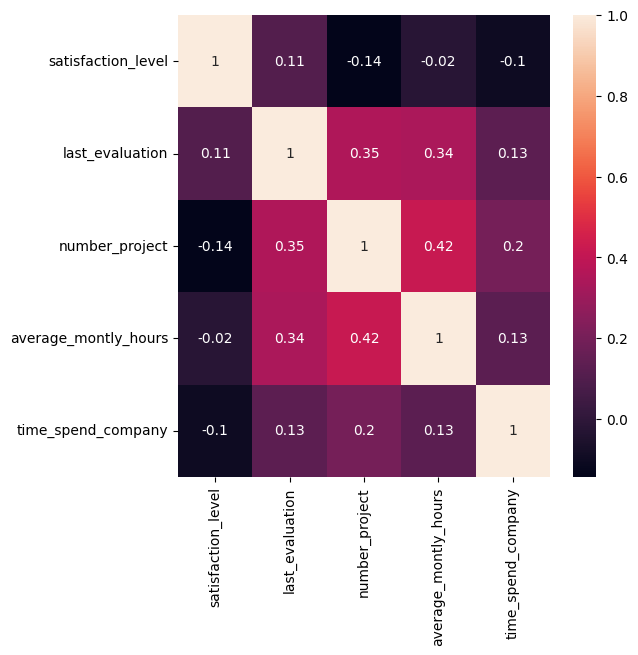

In [7]:
# La matriz de correlación de las varaibles numéricas nos indica que no se
# observan correlaciones altas entre ellas, es decir, se tiene una
# multicolinealidad baja:

correlations = df_Tnum[num_list].corr()
f, ax = plt.subplots(figsize = (6,6))
sns.heatmap(correlations, annot = True);

# **KPrototype : KMeans para variables numéricas y categóricas.**



#### **Recordemos que KMeans es una técnica para variables numéricas ya que está basada en la distancia (por ejemplo, euclideana) entre puntos. Para el caso de variables categóricas, dicha "distancia" será ahora la Moda y la similitud será la diferencia entre los distintos niveles.**

#### **Para ello debemos usar la librería KModes para datos solamente categóricos, o bien KPrototype, para conjunto de datos mixtos (numéricos y categóricos).**

#### **Toma en cuenta que debido al proceso de estar manejando variables numéricas y categóricas, el método de KPrototype puede tomar varios minutos en terminarse.**

In [8]:
!pip install kmodes   # Debemos instalar KModes, que necesitaremos para KPrototype.

In [9]:
from kmodes.kprototypes import KPrototypes

In [10]:
df_Tnum.head().T

0         1         2         3         4
satisfaction_level    -2.102542 -0.936248  0.752869 -2.022108  0.431132
last_evaluation       -2.080109 -1.087016  0.840752  0.957587   0.89917
number_project         -1.46271  -1.46271  0.971174  2.593762  0.971174
average_montly_hours   -2.10309 -0.881799  1.220424  1.420635  0.439598
time_spend_company    -1.026055 -0.341166  1.713502  0.343723  1.028612
Work_accident                 0         0         0         0         0
promotion_last_5years         0         0         0         0         0
sales                     sales     sales     sales     sales     sales
salary                      low       low    medium    medium       low

Vemos la información de las variables categóricas:

In [11]:
df_Tnum['Work_accident'].value_counts()

0    12831
1     2169
Name: Work_accident, dtype: int64

In [12]:
df_Tnum['promotion_last_5years'].value_counts()

0    14681
1      319
Name: promotion_last_5years, dtype: int64

In [13]:
df_Tnum['sales'].value_counts()

sales          4141
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

In [14]:
df_Tnum['salary'].value_counts()

low       7317
medium    6446
high      1237
Name: salary, dtype: int64

#### **Método de inicialización de KModes y KPrototype:**

Existen varias técnicas de inicialización de las variables catagóricas, en particular usaremos la llamada "Huang", la cual selecciona los primeros "K" registros distintos para iniciar con "K-Modes". Recordemos que en KModes se utuliza la moda en lugar del promedio aritmético que se aplica en las numéricas.

La "distancia" o "diferencia" entre un dato y un centroide será la suma de la diferencia de la parte numérica más la parte categórica. La parte numérica se calcula con la distancia euclideana usual sobre las coordenadas numéricas. Y la parte categórica mide la distancia de un dato a un centroide, como la cantidad de coordenadas categóricas diferentes dentre el dato y el centroide.

Las variables categóricas no requieren ser transformadas, solamente hay que indicar cuáles son y el algoritmo se encargará de tratarlas como tales.

Puedes consultar la siguiente liga de la documentación:

https://kprototypes.readthedocs.io/en/latest/api.html

Text(0, 0.5, 'Inercia')

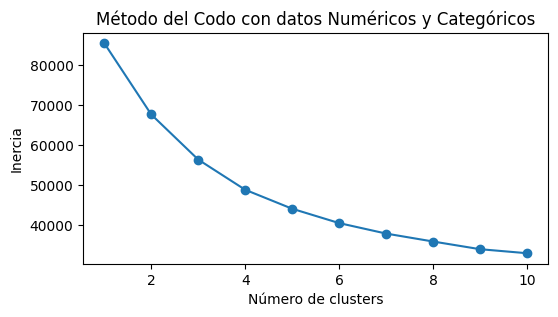

In [15]:
# Apliquemos el método de KMeans para datos mixtos (numéricos y categóricos)

#                                                            ...esta celda tarda 45 mins aprox en Google-Colab ...

ssecat = []    # Suma del cuadrado de los errores numéricos y categóricos .

k_list = range(1, 11)

cat_cols = [5,6,7,8]  # cat_list

for k in k_list:
    kp = KPrototypes(n_clusters=k, init='Huang', n_init=5)    # Inicializamos KMeans-con-varaibles-Mixtas
    kp.fit(df_Tnum , categorical=cat_cols)     # debemos indicarle cuáles son las variables categóricas.
    ssecat.append([k, kp.cost_])   # Calculamos la incercia de cada dato, numérica y categórica conjunta.


oca_results_scale = pd.DataFrame({'Cluster': range(1,11), 'SSE-CAT': ssecat})

plt.figure(figsize=(6,3))
plt.plot(pd.DataFrame(ssecat)[0], pd.DataFrame(ssecat)[1], marker='o')
plt.title('Método del Codo con datos Numéricos y Categóricos')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')

# **Ejercicio - 1:**

Basandonos en la gráfica con el método del codo el cual busca el punto en el cual la disminución de la suma de cuadrados para los clusters disminuye significativamente y fomando un codo por lo que el valor que considero más optimo es el 5 pues la inercia se reduce bastante sin estancarse además de que posteriormente los valores reducen cada vez menos.

In [16]:
# Selecciona el valor del entero "k" de kMeans, la cantidad de subgrupos o
# cúmulos (clusters) que creas adecuado siguiendo la técnica del codo
# y de acuerdo a la gráfica obtenida en la celda anterior:


# ************* Inlcuye aquí tu código:******************************

k_clusters_KProto = 5

# *********** Aquí termina la sección de agregar código *************


Recordemos que el Autoencoder es una red neuronal artificial, por lo que ahora sí requerimos transformar también las variables categóricas.

In [17]:
# Escalando la variable Ordinal:

df_Tnumord = df_Tnum.copy()

ordenc = OrdinalEncoder()
df_Tnumord[['salary']] = ordenc.fit_transform(df_Tnumord[['salary']])

df_Tnumord.head().T

0         1         2         3         4
satisfaction_level    -2.102542 -0.936248  0.752869 -2.022108  0.431132
last_evaluation       -2.080109 -1.087016  0.840752  0.957587   0.89917
number_project         -1.46271  -1.46271  0.971174  2.593762  0.971174
average_montly_hours   -2.10309 -0.881799  1.220424  1.420635  0.439598
time_spend_company    -1.026055 -0.341166  1.713502  0.343723  1.028612
Work_accident                 0         0         0         0         0
promotion_last_5years         0         0         0         0         0
sales                     sales     sales     sales     sales     sales
salary                      1.0       1.0       2.0       2.0       1.0

Las variables binarias las dejaremos como tales y la nominal aplicaremos one-hot-encoding con el método get_dummies() de Pandas:

In [18]:
X_Tnumordnom = df_Tnumord.copy()   # transformemos la variable Nominal con las Dummies de Pandas.

X_Tnumordnom = pd.get_dummies(X_Tnumordnom, columns=['sales'], drop_first=True)

df_Tnumordnom = pd.DataFrame(X_Tnumordnom)

print(df_Tnumordnom.shape)
df_Tnumordnom.head().T

(15000, 17)


0         1         2         3         4
satisfaction_level    -2.102542 -0.936248  0.752869 -2.022108  0.431132
last_evaluation       -2.080109 -1.087016  0.840752  0.957587  0.899170
number_project        -1.462710 -1.462710  0.971174  2.593762  0.971174
average_montly_hours  -2.103090 -0.881799  1.220424  1.420635  0.439598
time_spend_company    -1.026055 -0.341166  1.713502  0.343723  1.028612
Work_accident          0.000000  0.000000  0.000000  0.000000  0.000000
promotion_last_5years  0.000000  0.000000  0.000000  0.000000  0.000000
salary                 1.000000  1.000000  2.000000  2.000000  1.000000
sales_RandD            0.000000  0.000000  0.000000  0.000000  0.000000
sales_accounting       0.000000  0.000000  0.000000  0.000000  0.000000
sales_hr               0.000000  0.000000  0.000000  0.000000  0.000000
sales_management       0.000000  0.000000  0.000000  0.000000  0.000000
sales_marketing        0.000000  0.000000  0.000000  0.000000  0.000000
sales_product_mng      0.000000  0.000000  0.000000  0.000000  0.000000
sales_sales            1.000000  1.000000  1.000000  1.000000  1.000000
sales_support          0.000000  0.000000  0.000000  0.000000  0.000000
sales_technical        0.000000  0.000000  0.000000  0.000000  0.000000

# **Modelo AUTOENCODER**

In [19]:
# Definamos una arquitectura Autoencoder de manera usual para el caso de
# búsqueda de conglomerados: iniciar en el Encoder incrementando las primeras
# capas densas ocultas para deshacer lo mayor posible la dependencia de los
# factores, para posteriormente proyectarlos al espacio latente Z de menor
# dimensión. Cuando decimos de menor dimensión, es con respecto a la dimensión
# de los factores de entrada. En particular usaremos aproximadamente la mitad
# de los nodos/factores de entrada (que son 17).
# Posteriormente el Decoder será un espejo del
# Encoder, salvo alguna capa que podemos eliminar para que no se tenga una
# simetría completa y obtengamos algo más que simplemente vectores muy
# similares a los iniciales de entrada.
# Cada capa densa la inicializamos con Xavier-Glorot y usamos ReLU como
# función de activación.
# Finalmente usamos Adam como optimizador y la suma de cuadrados para la
# función de costo.

input_factors = df_Tnumordnom.shape[1]  # cantidad de factores en los datos de entrada.
int_z_latent = 8     # Dimensión del espacio latente Z.
encoding_dim = k_clusters_KProto  # valor k que determinaste en el método del codo del Ejercicio 1.

input_df = Input(shape=(input_factors, ))

# Capas del ENCODER:
x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(400, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(400, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(1500, activation='relu', kernel_initializer='glorot_uniform')(x)

# ESPACIO LATENTE Z:
encoded = Dense(int_z_latent, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)

# Capas del DECODER:
x = Dense(1500, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(400, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense( input_factors, kernel_initializer = 'glorot_uniform')(x)

# Generamos los modelos Autoencoder y Encoder:
autoencoder = Model(input_df, decoded)  # Modelo Autoencoder: (entrada de datos iniciales) + (Encoder) + (espacio-Z-latente) + (Decoder).
encoder = Model(input_df, encoded)      # Modelo Encoder:  (entrada de datos iniciales) + (Encoder) + (espacio-Z-latente).

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Pasamos al proceso de entrenamiento del Autoencoder.
# Aunque solo requeriremos en este ejercicio el Encoder, en el proceso debemos
# también generar el Decoder:

autoencoder.fit(df_Tnumordnom, df_Tnumordnom, batch_size=256, epochs = 30, verbose = 1)


Epoch 1/30
59/59 [==============================] - 12s 131ms/step - loss: 0.2518
Epoch 2/30
59/59 [==============================] - 9s 156ms/step - loss: 0.1597
Epoch 3/30
59/59 [==============================] - 6s 104ms/step - loss: 0.1331
Epoch 4/30
59/59 [==============================] - 8s 137ms/step - loss: 0.1181
Epoch 5/30
59/59 [==============================] - 7s 115ms/step - loss: 0.1086
Epoch 6/30
59/59 [==============================] - 8s 142ms/step - loss: 0.1011
Epoch 7/30
59/59 [==============================] - 7s 116ms/step - loss: 0.0962
Epoch 8/30
59/59 [==============================] - 8s 128ms/step - loss: 0.0927
Epoch 9/30
59/59 [==============================] - 6s 99ms/step - loss: 0.0895
Epoch 10/30
59/59 [==============================] - 3s 53ms/step - loss: 0.0872
Epoch 11/30
59/59 [==============================] - 5s 86ms/step - loss: 0.0850
Epoch 12/30
59/59 [==============================] - 3s 56ms/step - loss: 0.0829
Epoch 13/30
59/59 [=========

In [20]:
pred_Z_latente = encoder.predict(df_Tnumordnom)   # generamos los vectores en el espacio latente Z a la salida del Encoder.

469/469 [==============================] - 2s 3ms/step


In [21]:
pred_Z_latente.shape   # dimensión de los vectores en el espacio latente

(15000, 8)

Ahora, con base a los vectores latentes obtenidos con el Autoencoder, apliquemos kMeans (con el método usual para variables numéricas) para seleccionar cuántos cúmulos podríamos generar con estos vectores para obtener información sobre los empleados de la empresa y su potencial salida de la misma.

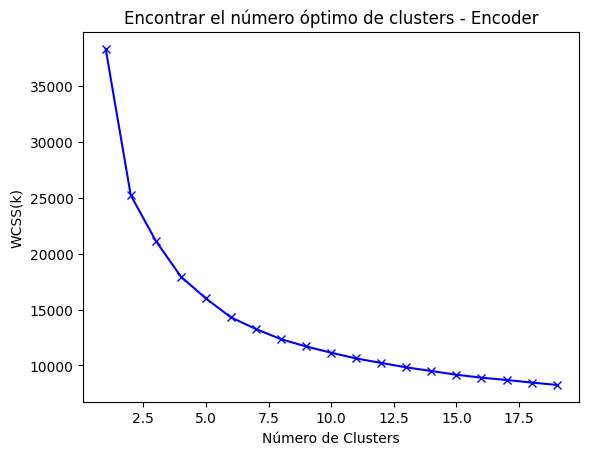

In [22]:
scores_Z = []                                          #    tarda menos de 1 min

range_values = range(1,20)

for i in range_values:
    kmeans = KMeans(n_clusters = i, n_init=10)
    kmeans.fit(pred_Z_latente)
    scores_Z.append(kmeans.inertia_)   # WCSS : within-cluster sum of square


plt.plot(range_values, scores_Z, 'bx-')
plt.title("Encontrar el número óptimo de clusters - Encoder")
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS(k)")
plt.show()

Basándonos en el método del codo, podríamos decir que 5, 6 o 7 cúmulos serían adecuados.

Veamos que valor de K obtenemos con la técnica Silhouette.

Si no conoces esta técnica, puedes consultar la documentación correspondiente en la siguiente liga:

https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html


In [23]:
from yellowbrick.cluster import SilhouetteVisualizer

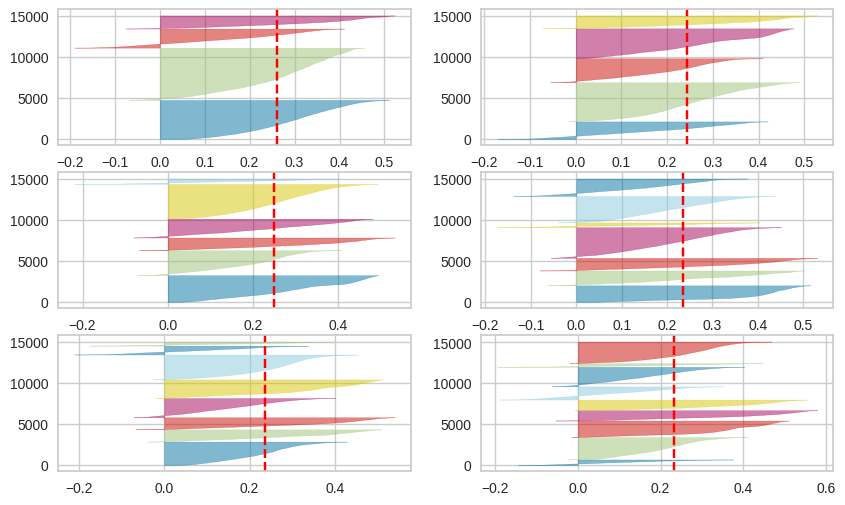

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(10,6))            # tarda se 1 a 2 mins

for i in [4,5,6,7,8,9]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=7)
    q, mod = divmod(i-2, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pred_Z_latente)

# **Ejercicio - 2:**

En base a analizar el gráfico generado por Silhouette considero que 6 sería un buen valor para el análisis ya que la mayoría de conos son de un tamaño similar además de que solo hay un pico negativo de mayor tamaño mientras que el resto son más pequeños lo que nos otorga un mejor análisis

In [25]:
# Selecciona el valor del entero "k" del número de cúmulos con base a lo
# observado los gráficoa de la técnica del codo y de silhouette.
# Observa que no necesriamente deben coincidir los valores observados
# por ambos métodos, por lo que deberás elegir el que consideres
# más adecuado:


# ************* Inlcuye aquí tu código:*****************************


k_clusters_Z_latente = 6



# *********** Aquí termina la sección de agregar código *************


In [26]:
km_Z_latent = KMeans(n_clusters= k_clusters_Z_latente,    # valor que seleccionaste en el Ejercicio 2.
                     n_init=10,    # número de veces que selecciona vectores de inicialización y se queda con el de menor inercia.
                     max_iter=500,
                     init='k-means++').fit(pred_Z_latente)

labels_Z_latent = km_Z_latent.labels_    # etiquetas para cada registro-renglón de los datos de entrada.

In [27]:
pd.DataFrame(labels_Z_latent).value_counts()   # Tamaño de los clusters obtenidos con el método del Autoencoder.

5    4229
1    3270
2    3034
4    2287
0    1532
3     648
dtype: int64

In [28]:
# Apliquemos PCA ahora a los vectores latentes obtenidos para proyectarlos y
# visualizarlos en un espacio de dimensión 2:

pca = PCA(n_components=2)
princ_comp = pca.fit_transform(pred_Z_latente)
pca_df = pd.DataFrame(data = princ_comp, columns=["pca1", "pca2"])
pca_df = pd.concat([pca_df, pd.DataFrame({"cluster":labels_Z_latent})], axis = 1)
pca_df.head(3)

pca1      pca2  cluster
0 -1.762951 -0.259492        1
1 -1.578855  0.286933        1
2  2.400390  0.323948        4

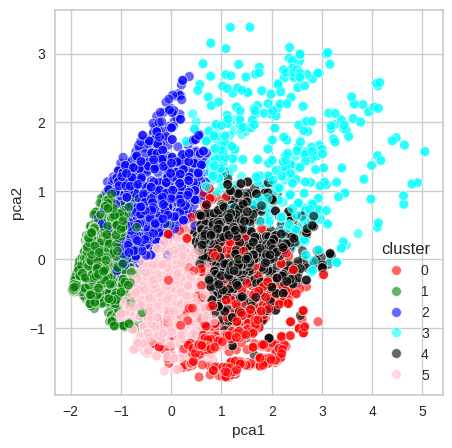

In [29]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x="pca1", y = "pca2", hue="cluster", data = pca_df,
                     alpha=0.6,
                     palette=["red", "green", "blue","cyan", "black",'pink','orange', "yellow"])
plt.show()

In [30]:
# Concatenamos la información de las etiquetas de cada registro del dataframe de
# entrada indicando además en qué cúmulo se encuentran.
# Es importante tener los valores iniciales sin transformar con la información
# de a qué cumulo pertenece para poder darles un mejor significado desde el
# punto de vista del negocio, en este caso sobre cada factor y su impacto en
# la posible salida de un empleado.

cluster_Z_latent_perfiles = pd.concat([dftodos, pd.DataFrame({'autoencoder_clusters':labels_Z_latent})], axis=1 )

cluster_Z_latent_perfiles.head().T

0      1       2       3      4
satisfaction_level      0.09   0.38     0.8    0.11   0.72
last_evaluation         0.36   0.53    0.86    0.88   0.87
number_project             2      2       5       7      5
average_montly_hours      96    157     262     272    223
time_spend_company         2      3       6       4      5
Work_accident              0      0       0       0      0
promotion_last_5years      0      0       0       0      0
sales                  sales  sales   sales   sales  sales
salary                   low    low  medium  medium    low
autoencoder_clusters       1      1       4       0      4

# **PCA - Análisis de Componentes Principales**



Aplicaremos ahora la técnica PCA a los datos iniciales para generar igualmente cúmulos y compararlo con lo obtenido con la técnica de Autoencoder previamente vista. Esta técnica es más conocida y generalemente la que se aplica en primera instancia en un problema de agrupamiento (clustering).

En este caso lo haremos tomando directamente las decisiones sobre los gráficos que estarmos generando:

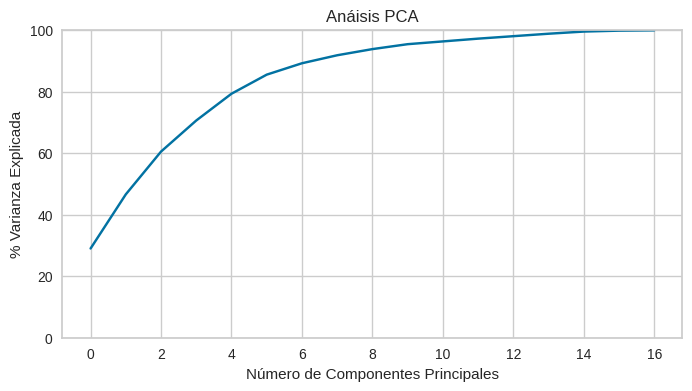

In [31]:
# Consideremos el DataFrame con los 17 vectores transformados
# y apliquemos PCA con todos ellos para ver qué cantidad de
# componenes principales podrían ser suficientes para un análisis
# de relación factores y cúmulos que formaremos:

pca = PCA(n_components= df_Tnumordnom.shape[1], random_state=5)
pca.fit(df_Tnumordnom)

variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)

plt.figure(figsize=(8,4))
plt.ylabel('% Varianza Explicada')
plt.xlabel('Número de Componentes Principales')
plt.title('Anáisis PCA')
plt.ylim(0,100.1)
plt.plot(var);

#### **Vemos que con 4 o 6 componentes principales se explica aproximadamente entre el 80% y 90% de su varianza.**

#### **Selecconaremos el valor de 6 componentes principales (que implica cerca del 90% de la variabilidad de los datos) para fines de este ejercicio y a continuación veamos cuántos cúmulos podrían ser adecuados usar al aplicar el método de conglomerados (clustering).**

Text(0, 0.5, 'Inercia')

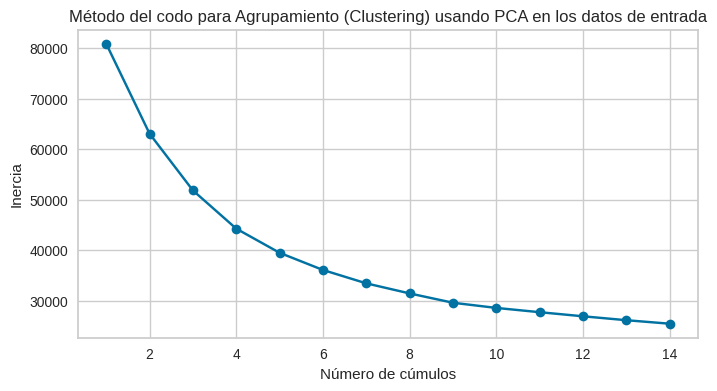

In [32]:
                                                            #  tarda menos de 1 min
pca = PCA(n_components=6)    # seleccionamos 6 componentes principales que tienen un 90% de la varibilidad total
pca_T = pca.fit_transform(df_Tnumordnom)
pca_df_T = pd.DataFrame(pca_T, columns=['pc1','pc2','pc3','pc4','pc5','pc6'])


sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k,n_init=7,random_state=7)
    km.fit(pca_df_T)
    sse.append([k, km.inertia_])

pca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(8,4))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Método del codo para Agrupamiento (Clustering) usando PCA en los datos de entrada')
plt.xlabel('Número de cúmulos')
plt.ylabel('Inercia')

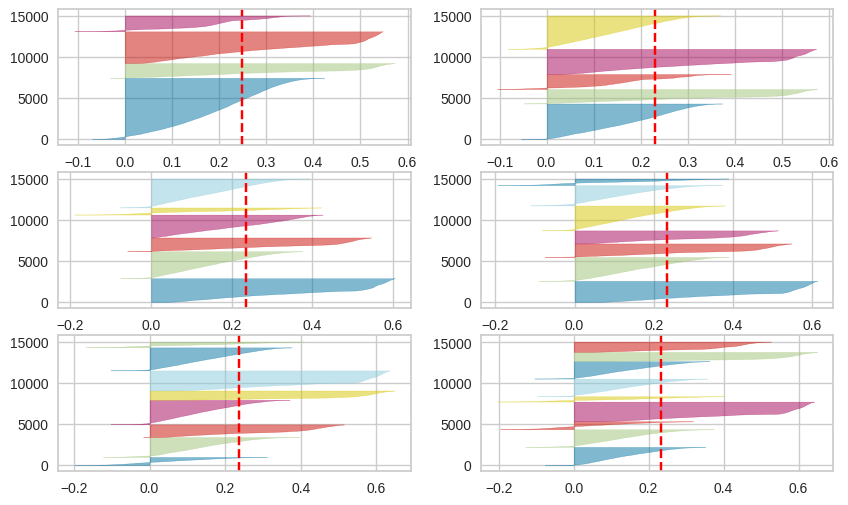

In [33]:
# Veamos también el método Silhouette a ver que nos dice:

fig, ax = plt.subplots(3, 2, figsize=(10,6))                            # tarda como 1 min

for i in [4,5,6,7,8,9]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=7)
    q, mod = divmod(i-2, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pca_df_T)

De ambos análisis/gráficos observamos varias opciones, pero para fines de este ejercicio seleccionaremos el valor de 5 para la cantidad de cúmulos que consideamos más adecuada con estos 6 vectores de componentes principales que generamos.

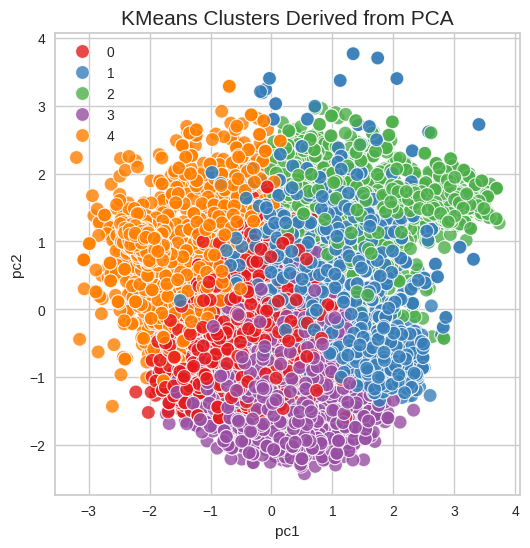

In [34]:
kmeans_pca_T = KMeans(n_clusters=5, n_init=7, max_iter=400, init='k-means++').fit(pca_df_T)

labels_pca_T = kmeans_pca_T.labels_

clusters_pca_T = pd.concat([pca_df_T, pd.DataFrame({'pca_clusters':labels_pca_T})], axis=1)



# Grafiquemos las primeras 2 componentes principales del método PCA :
plt.figure(figsize = (6,6))
sns.scatterplot(x=clusters_pca_T['pc1'],
                y=clusters_pca_T['pc2'],
                hue=labels_pca_T,
                palette='Set1',
                s=100,
                alpha=0.8
                ).set_title('KMeans Clusters Derived from PCA', fontsize=15)

plt.legend()
plt.show()

In [35]:
# Concatenamos ahora el dataFrame de datos originales con los cúmulos identificados
# mediante las componentes principales de los datos de entrada:

cluster_pca_perfiles = pd.concat([dftodos, pd.DataFrame(clusters_pca_T['pca_clusters'])], axis=1 )
cluster_pca_perfiles.head().T

0      1       2       3      4
satisfaction_level      0.09   0.38     0.8    0.11   0.72
last_evaluation         0.36   0.53    0.86    0.88   0.87
number_project             2      2       5       7      5
average_montly_hours      96    157     262     272    223
time_spend_company         2      3       6       4      5
Work_accident              0      0       0       0      0
promotion_last_5years      0      0       0       0      0
sales                  sales  sales   sales   sales  sales
salary                   low    low  medium  medium    low
pca_clusters               4      4       1       2      1

# **Relaciones entre factores de acuerdo a los cúmulos**

In [36]:
fact1 = 'last_evaluation'
fact2 = 'satisfaction_level'

mi_scatterplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
box = (cluster_Z_latent_perfiles['last_evaluation'] < 0.56 ) & (cluster_Z_latent_perfiles['last_evaluation'] > 0.44) & (cluster_Z_latent_perfiles['satisfaction_level'] < 0.47 ) & (cluster_Z_latent_perfiles['satisfaction_level'] > 0.36)

cluster_Z_latent_perfiles[box]

satisfaction_level  last_evaluation  number_project  \
1                    0.38             0.53               2   
5                    0.37             0.52               2   
6                    0.41             0.50               2   
10                   0.42             0.53               2   
11                   0.45             0.54               2   
...                   ...              ...             ...   
14989                0.46             0.55               2   
14993                0.40             0.48               2   
14996                0.37             0.48               2   
14997                0.37             0.53               2   
14999                0.37             0.52               2   

       average_montly_hours  time_spend_company  Work_accident  \
1                       157                   3              0   
5                       159                   3              0   
6                       153                   3              0   
10                      142                   3              0   
11                      135                   3              0   
...                     ...                 ...            ...   
14989                   145                   3              0   
14993                   155                   3              0   
14996                   160                   3              0   
14997                   143                   3              0   
14999                   158                   3              0   

       promotion_last_5years      sales salary  autoencoder_clusters  
1                          0      sales    low                     1  
5                          0      sales    low                     1  
6                          0      sales    low                     1  
10                         0      sales    low                     1  
11                         0      sales    low                     1  
...                      ...        ...    ...                   ...  
14989                      0  technical    low                     1  
14993                      0    support    low                     1  
14996                      0    support    low                     1  
14997                      0    support    low                     1  
14999                      0    support    low                     1  

[1315 rows x 10 columns]

# **Ejercicio - 3:**

### **Con base a los gráficos dados en los siguientes pares de factores y en relación a los subgrupos o cúmulos observados por el método de Autoencoders y el de PCA, incluye alguna interpretación del mismo que ayude a entender mejor al departamento de recursos humanos el ambiente de trabajo dentro de la empresa.**

In [38]:
# Ejercicio 3a:


fact1 = 'last_evaluation'
fact2 = 'average_montly_hours'

mi_scatterplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

Output hidden; open in https://colab.research.google.com to view.

## **Ejercicio 3a:**

++++++++ Inicia la sección de agregar texto: +++++++++++

En los siguientes gráficos podemos observar similitudes respecto a que existe un grupo localizado en last evaluation igual a 0.5 y un average monthly hours de 150 con lo cual es posible entender que los trabajadores con menos horas trabajadas recibe una evaluación mas baja.

Existe el conjunto opuesto un poco menos perceptible ubicado en last evaluation de 0.9 y average de 280 aproximadamente lo que indica que a más horas trabajadas una mejor evaluación

Mediante PCA es posible notar otro patron que el autoencoder no fue capaz de definir los colores azul y morado forman dos grandes bloques casí simetricos que nos indican que la mayoria de evaluaciones son proporcionales a las horas trabajadas.

++++++++ Termina la sección de agregar texto. +++++++++++

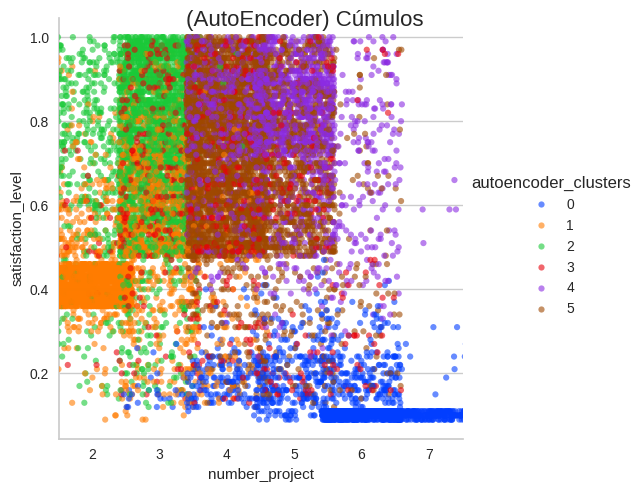

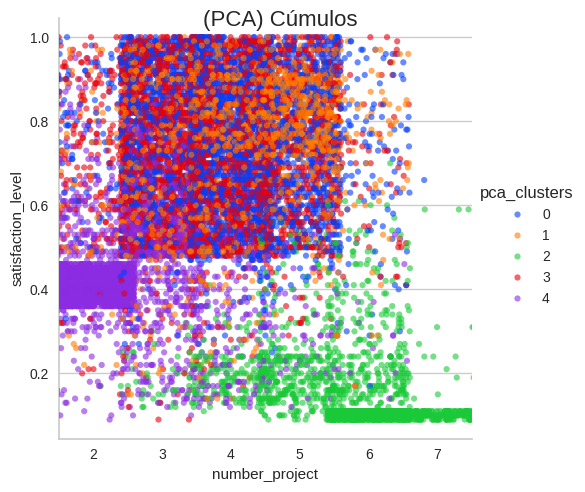

In [61]:
# Ejercicio 3b:

fact1 = 'number_project'
fact2 = 'satisfaction_level'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3b:**

++++++++ Inicia la sección de agregar texto: +++++++++++

Para estos gráficos es posible notar lo siguiente:

Existe un pequeño grupo de 1 a 2 proyectos con un nivel de satisfacción bajo esto nos ínidica que este sector desea poder tener un mayor impacto en la compañia y que posiblemente deseen ser incluidos en más proyectos. Por lo que sería conveniente analizar el comportamiento de estos trabajadores para saber si realmente serían capaces de llevar más proyectos.

Notamos un estrato inverso que sería el más preocupante ya que su satisfacción es casi cero y estan cargados con 4 a 7 proyectos por lo que sería conveniente traspasar algunos de estos trabajos al sector anterior.

El conjunto más grand es aquel donde los trabajadores tienen de 2 a 5 proyectos y reportan un alto nivel de satisfacción.

++++++++ Termina la sección de agregar texto. +++++++++++

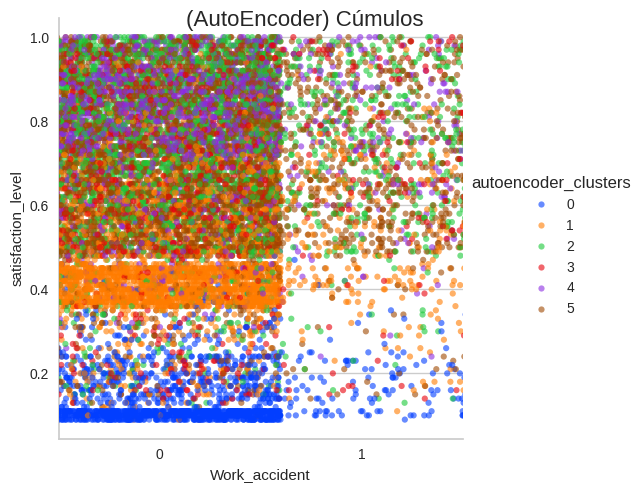

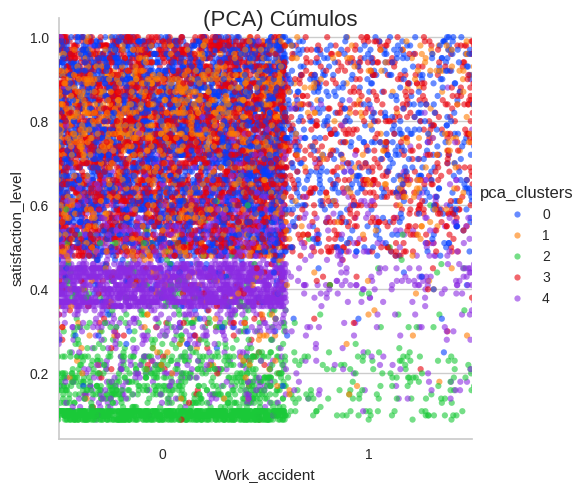

In [40]:
# Ejercicio 3c:


fact1 = 'Work_accident'
fact2 = 'satisfaction_level'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3c:**

++++++++ Inicia la sección de agregar texto: +++++++++++

De estos gráficos un primer hallazgo relevante es que la densidad más grande de muestras se encuentra en la categoría de NO accidentes, dentro de esta categoría existen 3 estratificaciones donde la mayoría de trabajadores reportan un satisfacción de 0.5 a 1, un grupo mas reducido se situa en valores cercanos a 0.4, y una pequeña franja densa corresponde a valores cercanos a cero, por lo que valdría la pena descubrir que otra métrica tienen en común estos usuarios.

++++++++ Termina la sección de agregar texto. +++++++++++

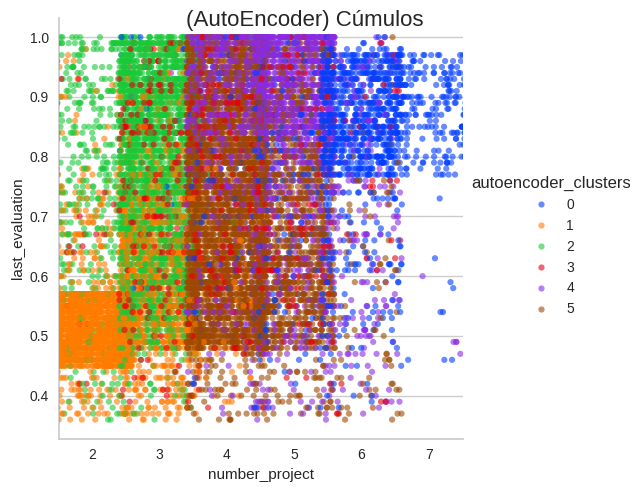

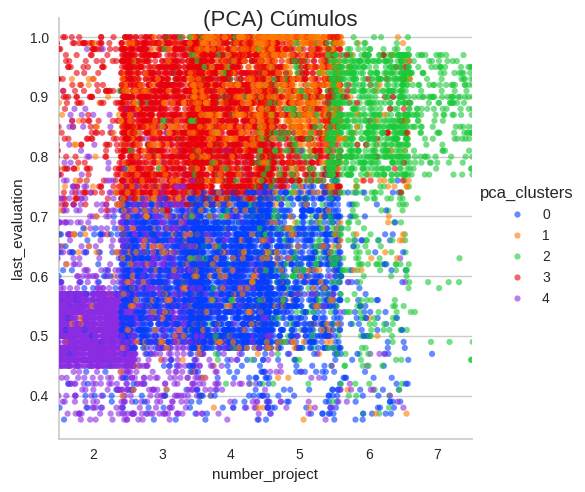

In [41]:
# Ejercicio 3d:

fact1 = 'number_project'
fact2 = 'last_evaluation'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3d:**

++++++++ Inicia la sección de agregar texto: +++++++++++

Haciendo un segundo análisis al número de proyectos podemos ver que la calificación asignada en evaluación es mayor seguún aumenta el número de proyectos además hay dos grupos grandes con proyectos de 3 a 5 donde una mitad es de 0.5 a 0.75 y la otra mitad de 0.75 a 1 por lo que podriamos analizar las características que definen al grupo superior para tratar de replicar algo en el inferior y reducirlo.

++++++++ Termina la sección de agregar texto. +++++++++++

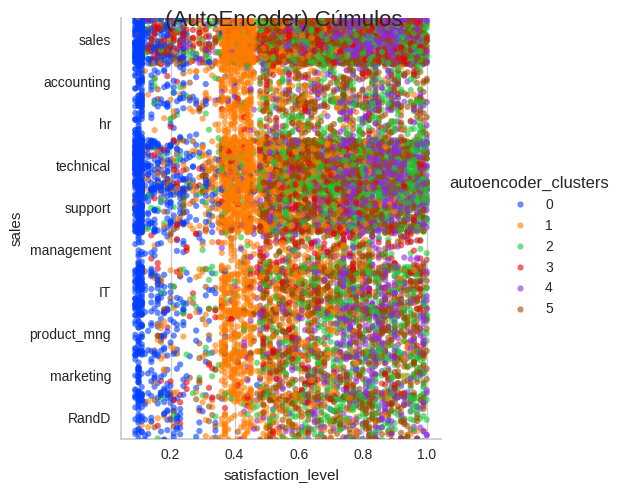

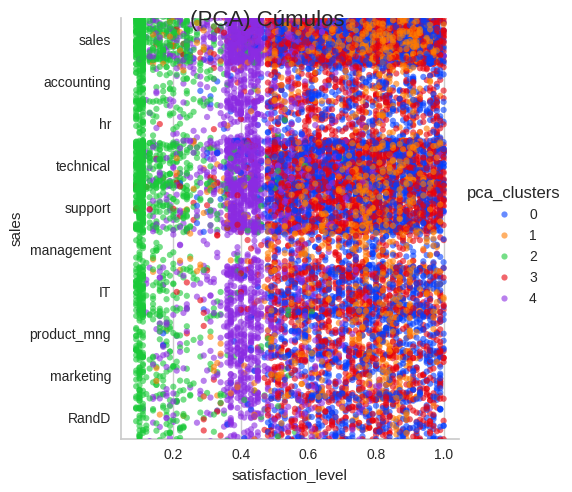

In [42]:
# Ejercicio 3e:

fact2 = 'sales'
fact1 = 'satisfaction_level'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3e:**

++++++++ Inicia la sección de agregar texto: +++++++++++

Como primer hallazgo es posible notar que los clusters resultan más marcados con PCA ya que con autoencoders los datos se encuentran más dispersos, en base a las categorías se puede ver las áreas en las que exiten mas muestras, además una información relevante es que el nivel de satisfacción en general es bueno siendo en una proporción de 60,30,10 siendo Alto, medio y bajo respectivamente

++++++++ Termina la sección de agregar texto. +++++++++++

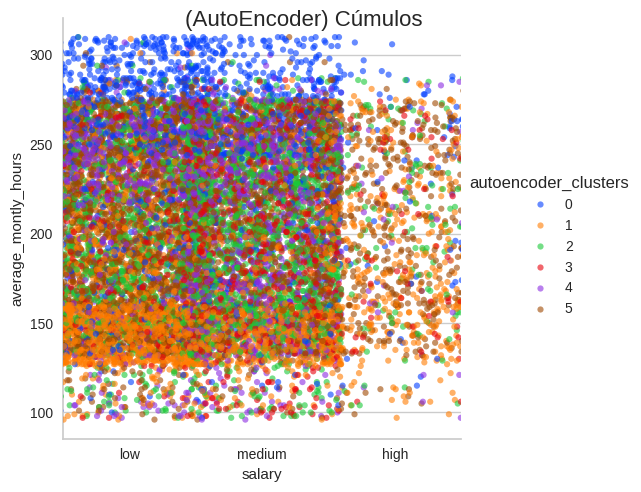

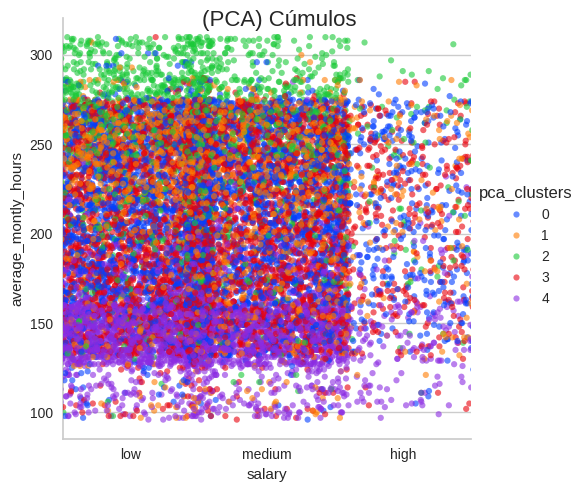

In [43]:
# Ejercicio 3f:


fact1 = 'salary'
fact2 = 'average_montly_hours'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3f:**

++++++++ Inicia la sección de agregar texto: +++++++++++

Aqui notamos que la la mayoría de trabajadores se situa en randos de bajo hasta medio y que a pesar de trabajar más horas no hay alguna mejora económica lo que debe ser una area de mejora para la empresa recompensar a los trabajadores que dedican más horas

++++++++ Termina la sección de agregar texto. +++++++++++

## **Ejercicio 3g:**

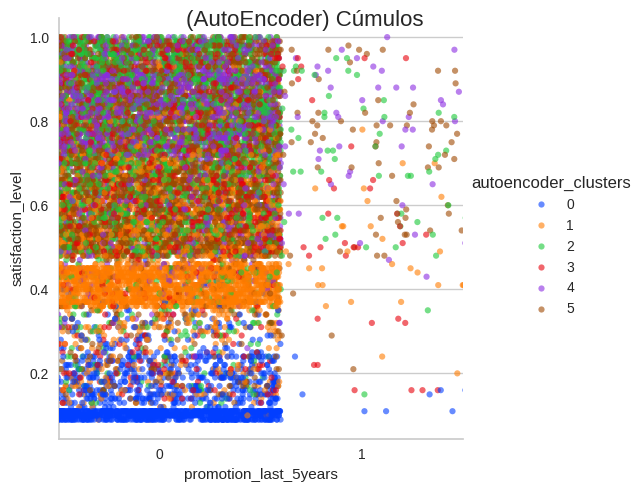

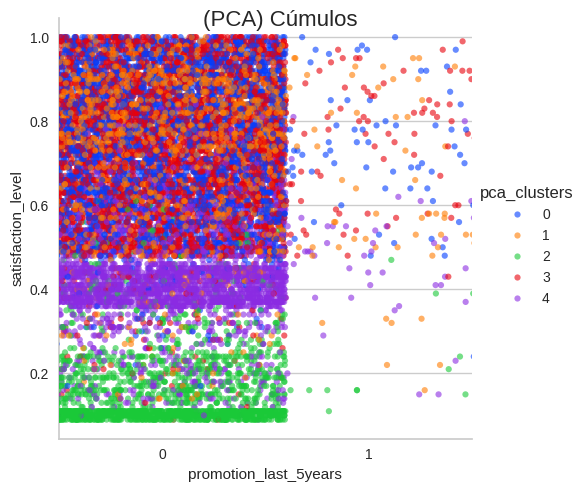

In [44]:
# Incluye algún otro gráfico y tus comentarios de otra relación entre variables
# que consideres proporcione información importante al problema.


# ******************** Incluuye a continuación tu código **********************

fact1 = 'promotion_last_5years'
fact2 = 'satisfaction_level'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)


# *********************** Termina sección para agregar código *****************



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

De acuerdo a este análisis muy pocos trabajadores han recibido una promoción en los ultimos 5 años los datos para PCA y autoencoders no parecen lograr una muy buena división de varias categorias principalmente en los valores de 0.5 a 1.0 sin embargo podría considerarse que todos los grupos involucrados en esa área pueden tomarse como iguales.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

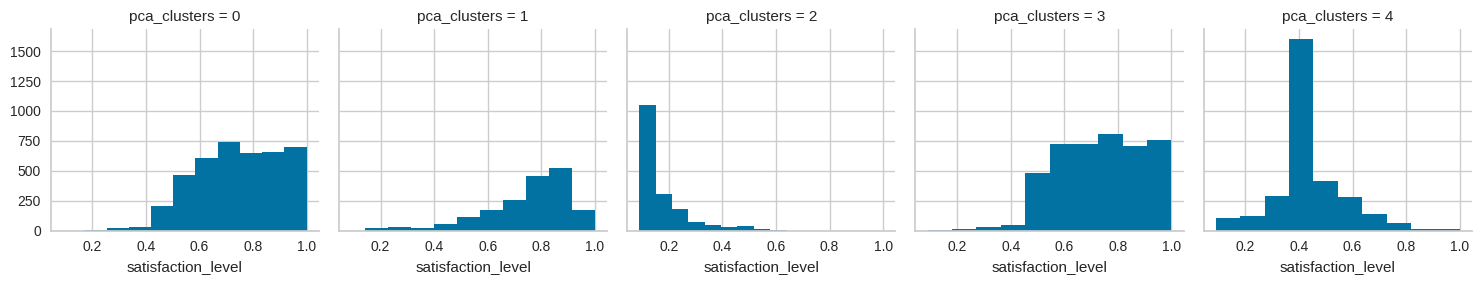

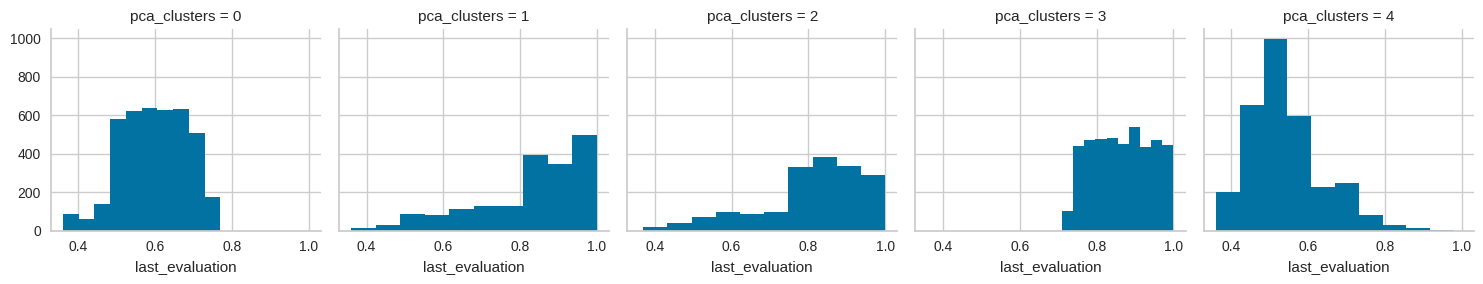

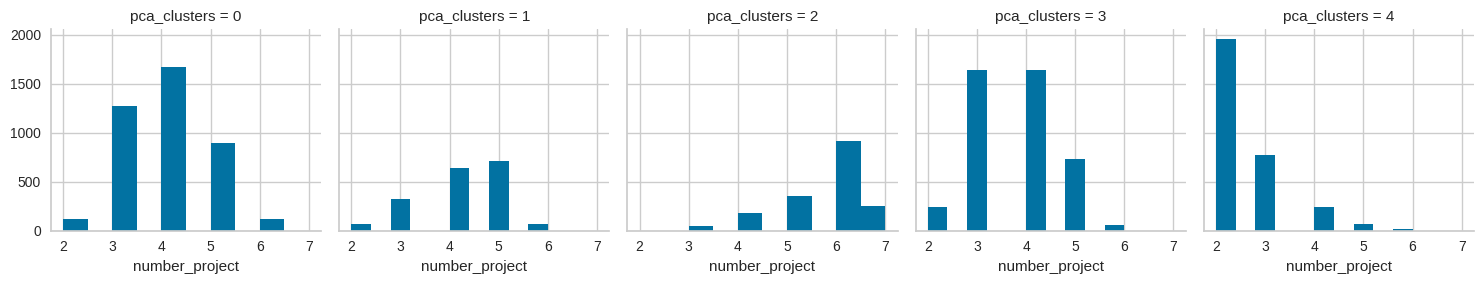

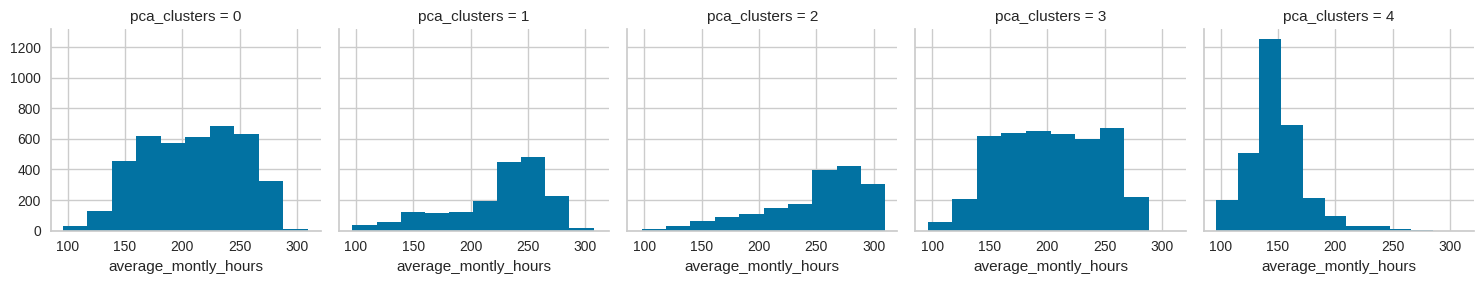

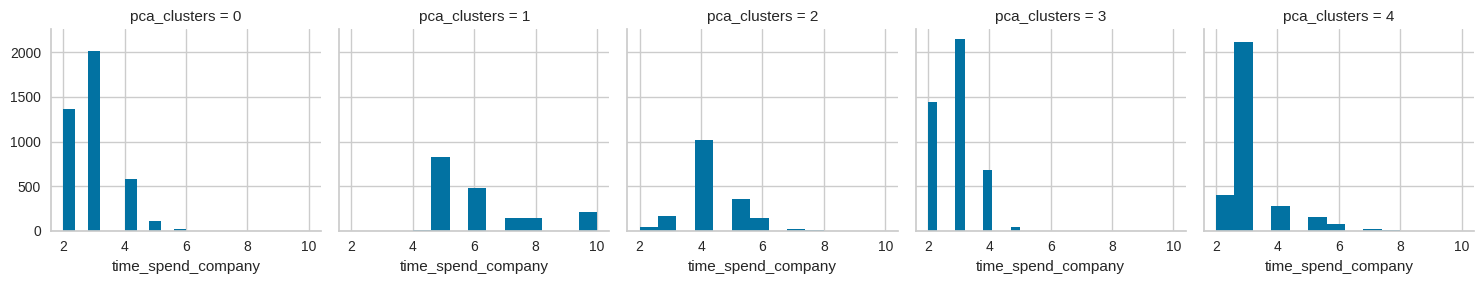

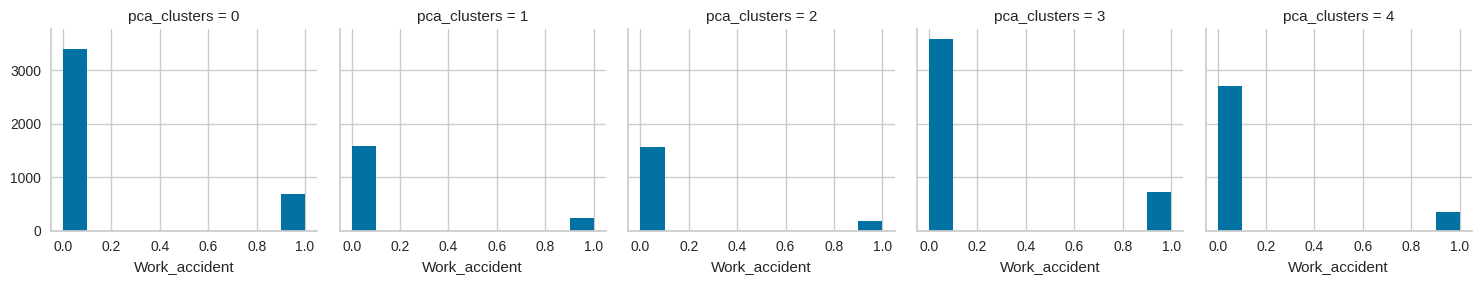

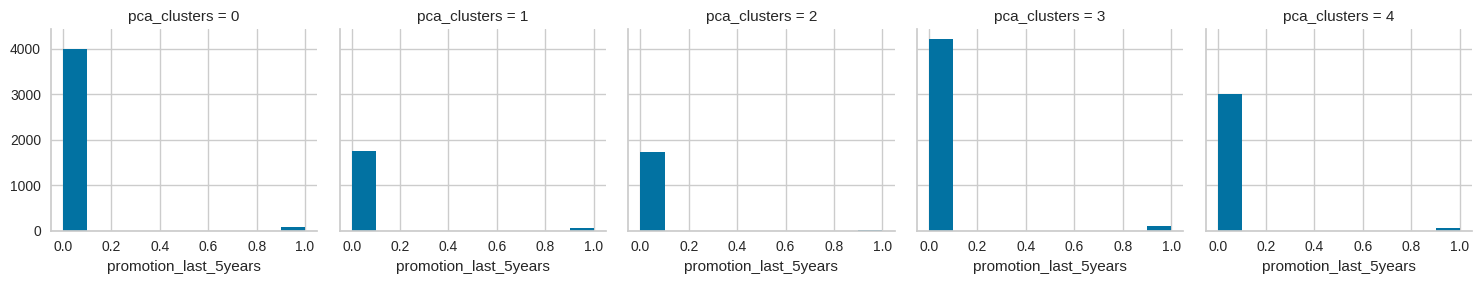

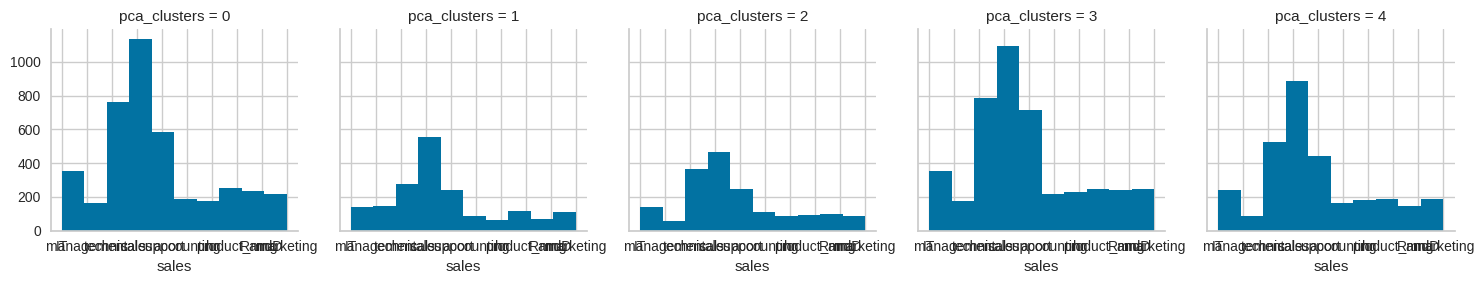

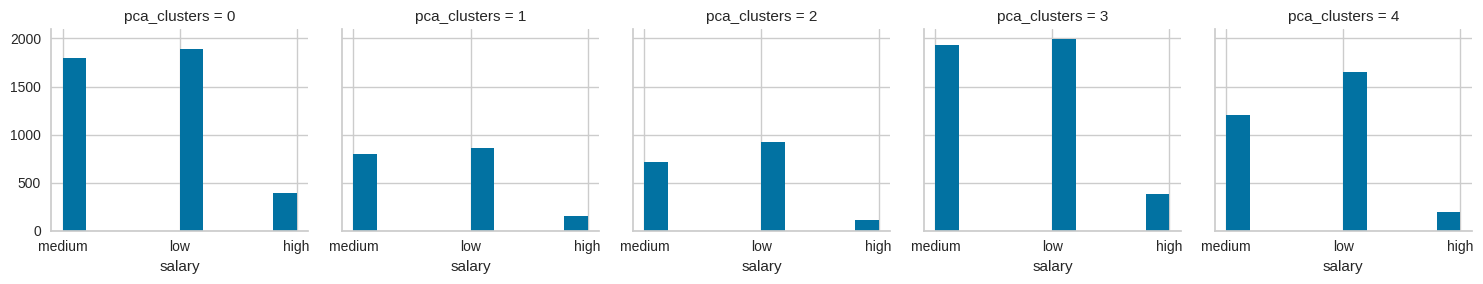

In [45]:
# Podemos obtener algunos diagramas adicionales que nos ayuden a entender
# mejor cada cúmulo y su relación con los factores que la forman.
# Sabemos que exiten una gran variedad de otros tipos e gráficos.
# En particular podemos mostrar los de los cúmulos obtenidos con el método
# de autoencoders solo como muestra y a manera de complemento de la
# información que hemos obtenida con los gráficos anteriores:

for c in cluster_pca_perfiles.iloc[:,:9]:
    grid = sns.FacetGrid(cluster_pca_perfiles, col='pca_clusters')
    grid.map(plt.hist, c)

# **Ejercicio - 4:**

#### **Incluye tus conclusiones y comentarios finales de la Actividad:**

++++++++ Inicia la sección de agregar texto: +++++++++++

Durante esta actividad nos centramos en dos metodos el de autoencoders y PCA para reducción de dimensionalidad para un problema de agrupamiento (clustering) en el dataset se contaba con datos númericos y categoricos por lo que fue necesario usar Kprototype que permite el procesamiento de los dos tipos de datos.

Mediante técnicas como la del codo y Silhouette es posible determinar el número de componentes que explican los datos una vez reducidos se busca el número ideal de clusters.

Una vez logrados los clusters con ambos métodos viene el proceso más importante que es la interpretación en base a las distintas variables es posible ver como los datos se agrupan lo que nos permitiría ver grupos de trabajadores que a lo mejor esten insatisfechos o esten teniendo exceso de trabajo o esten siendo evaluados con bajas califiaciones para tomar decisiones.

La toma de decisiones por medio del agrupamiento nos permite analizar un grupo de personas que comparten ciertas características y asi contrastarlo con otros grupos entendiendo que acciones se pueden realizar para que ciertos trabajadores salten de un sector a otro.

++++++++ Termina la sección de agregar texto. +++++++++++

>> **++++ Fin del la Actividad de la Semana de Autoencoders ++++**